# Предсказание стоимости жилья с помощью продвинутых методов регрессии. Задание House Prices с Kaggle

## Обзор задачи, входных данных

В этом проекте перед нами стоит реальная задача предсказания стоимости домов, учитывая 79 признаков, описывающих почти каждый аспект жилого дома. 

Критериями оценки этого конкурса на Kaggle является _RMSLE_ - среднеквадратичная ошибка между логарифмом прогнозируемого значения и логарифмом наблюдаемой цены продажи.

## Шаг 1. Выгрузка и исследование данных

Для начала мы импортируем необходимые библиотеки и наборы данных:

In [341]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from pycaret.regression import setup, compare_models


from catboost import  CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor

from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split #Разбивка данных на случайные подмножества тренировок и тестов
from sklearn.preprocessing import StandardScaler, OneHotEncoder #Стандартизация данных и кодирование категориальных величин
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline #Объединение нескольких этапов обработки данных в один последовательный процесс
from sklearn.impute import SimpleImputer #Замена недостающих данных, используя описательную статистику
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Выгрузка датасетов
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [342]:
train0

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [343]:
test0

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,Hd

На этом шаге уже хочется создать какой-то план действий внутри проекта

<ul> <strong> План: </strong>
<li>Чистка данных</li>
<li>Отсев признаков</li>
<li>Преобразование признаков</li>
<li>Кодирование</li>
<li>Масштабирование</li>
<li>Преобразование значений</li>
<li>Выбор модели</li>
<li>Оптимизация гиперпараметров</li>
<li>Составление ансамбля</li>
</ul>

Начнем работу с очистки данных

## Шаг 2. Чистка данных

In [344]:
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


Оценим общее количество пропущенных значений в каждом столбце:

In [345]:
train0.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [346]:
test0.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType        894
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

В тренировочном и тестовом наборах данных присутствуют пропущенные значения. Объединим данные, чтобы заполнить недостающие данные, а потом снова их разделим

In [347]:
target = train0['SalePrice']
test_ids = test0['Id']

train1 = train0.drop(['Id', 'SalePrice'], axis=1)
test1 = test0.drop('Id', axis=1)

data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,NaN,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,

In [348]:
target

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [349]:
data2 = data1.copy()

Далее выберем данные с правильными типами. Нас интересуют числовые значения

In [350]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

Просмотрев данные, я пришел к выводу что MSSubClass - единственный столбец, который был закодирован. Так что мы можем переходить к следующему пункту

### Заполнение пропущенных категориальных значений

Проанализируем входные данные (столбцы с категориальными величинами), разобьем их на 2 типа - где NaN несет какой-либо смысл для нашей задачи и где нет. В зависимости от этого перезаполним таблицу

In [351]:
# Impute using a constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna("None")
    
# Impute using the column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [352]:
data3 = data2.copy()

### Заполнение пропущенных числовых значений

Воcпользуемся kNN регрессией для заполнения отсутвующих числовых значений. Но перед этим создадим функцию заполнения какого-то столбца

In [353]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[:, numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

Проанализируем, какие столбцы нам нужно заполнить. Сделаем это с помощью функции, написанной выше

In [354]:
data3.columns[data3.isna().sum() > 0]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [355]:
for column in [
    'LotFrontage', 
    'MasVnrArea', 
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF', 
    'BsmtFullBath', 
    'BsmtHalfBath', 
    'GarageYrBlt',
    'GarageCars', 
    'GarageArea'
]:
    data3 = knn_impute(data3, column)

In [356]:
data4 = data3.copy()

На этом мы закончили очистку данных

## Разработка функций

In [357]:
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] +
                                                       data4["FullBath"] +
                                                       data4["HalfBath"] +
                                                       data4["KitchenAbvGr"])           #средняя площадь комнаты

data4['Total_Home_Quality'] = data4['OverallQual'] + data4['OverallCond']               #общее качество дома

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))   #общее количество ванных комнат

data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]       #общая площадь

In [358]:
data5 = data4.copy()

## Шаг 3. Преобразование признаков

In [359]:
data5

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,142.500000,12,3.5,1710
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,140.222222,14,2.5,1262
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,178.600000,12,3.5,1786
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,190.777778,12,2.0,1717
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,169.076923,13,3.5,2198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,BrkFace,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,None,None,1973.8,None,0.0,0.0,None,None,Y,0,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,136.500000,11,1.5,1092
2915,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,BrkFace,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,None,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,None,None,None,0,4,2006,WD,Abnorml,121.333333,9,1.5,1092
2916,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,12

Исследуем наши данные на предмет дисбалансности. Вычислим ассиметрию какого-то из столбцов. Например LotFrontage

In [360]:
scipy.stats.skew(data5['LotFrontage'])

1.3407511399227516

Как мы видим, имеется ассиметрия вправо. Вычислим ассиметрию для каждого из числовых столбцов и обратим это во фрейм данных

In [361]:
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False) #помечаем столбцы с ассиметрией >= 0.5
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [362]:
data5[skew_df.query("Skewed == True")['Feature'].values].describe()

,LotFrontage,LotArea,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SqFtPerRoom,Total_Home_Quality,HighQualSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,70.154916,10168.114080,5.564577,1971.312778,102.189654,441.332580,49.576841,560.797670,1051.679822,1159.581706,336.483727,4.694416,1500.759849,0.429805,0.061322,0.380267,1.044536,6.451524,0.597122,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,157.116695,11.653649,1496.065433
std,22.697641,7886.996359,1.113131,30.291442,178.934095,455.559081,169.176867,439.470508,440.722380,392.362079,428.701456,46.396825,506.051045,0.524573,0.245608,0.502872,0.214462,1.569379,0.646129,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,27.923999,1.712435,503.675790
min,21.000000,1300.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.400000,2.000000,334.000000
25%,60.000000,7478.000000,5.000000,1953.500000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,137.142857,11.000000,1120.000000
50%,70.000000,9453.000000,5.000000,1973.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,0.000000,1.000000,6.000000,1.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.285714,12.000000,1440.000000
75%,80.100000,11570.000000,6.000000,2001.000000,164.000000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,1.000000,1.000000,7.000000,1.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,172.333333,13.000000,1742.500000
max,313.000000,215245.000000,9.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,2.000000,3.000000,15.000000,4.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,352.625000,19.000000,5642.000000


Выше мы запросили описание данных из ассиметричных столбцов. Как видим, у многиъ из них минимальное значение равно нулю. Отрицательных данных нет, так как данные из реального мира. Но нам нужно прологарифмировать данные, чтобы избавится от ассиметрии, что для стандартной функции логарифма невозможно при нудевых данных. Воспользуемся функцией `log1p` из `NumPy`

In [363]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data5[column] = np.log1p(data5[column])

Проверим, как поменялась асимметрия:

In [364]:
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False) #помечаем столбцы с ассиметрией >= 0.5
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,-0.929468,0.929468,True
1,LotArea,-0.504751,0.504751,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,-0.746183,0.746183,True
4,YearBuilt,-0.626215,0.626215,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,0.511138,0.511138,True
7,BsmtFinSF1,-0.618036,0.618036,True
8,BsmtFinSF2,2.458996,2.458996,True
9,BsmtUnfSF,-2.159204,2.159204,True


Стало лучше. Но тут мы можем обратить внимание, что есть признаки, такие как `MoSold`. Посмотрим, что представляют из себя эти данные:

In [365]:
data5['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

Эти данные представляют из себя номера месяцев, но пока наша модель будет воспринимать их как числа, не смотря на то, что на самом деле `1` и `12`, к примеру, очень близки по сути друг к другу, так как обозначают холодное время года. Давайте применим к подобным признаком `косинусоидальное преобразование`, чтобы обратить "реальный" смысл признака в "численный"

Рассмотрим функцию $y = -\cos(0.5236 \cdot x)$ - в точках с $x = 0$ и $x = 12$, она принимает равные значения $y = -1$. Знак `-` показывает, что месяцы холодные.

In [366]:
data5['MoSold'] = -np.cos(0.5236 * data5['MoSold'])

In [367]:
data6 = data5.copy()

## Кодирование категориальных величин

Так как мы уже позаботились о приведении величин к нужной нам форме, закодировать их не проблема

In [368]:
data6 = pd.get_dummies(data6)

In [369]:
data7 = data6.copy()

## Стандартизация данных, масштабирование

Проведем стандартизацию с помощью `StandartScaler` из `sk-learn`

In [370]:
scaler = StandardScaler()
scaler.fit(data7)

data7 = pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns)

data8 = data7.copy()    

## Изменение целевых данных

<function matplotlib.pyplot.show(close=None, block=None)>

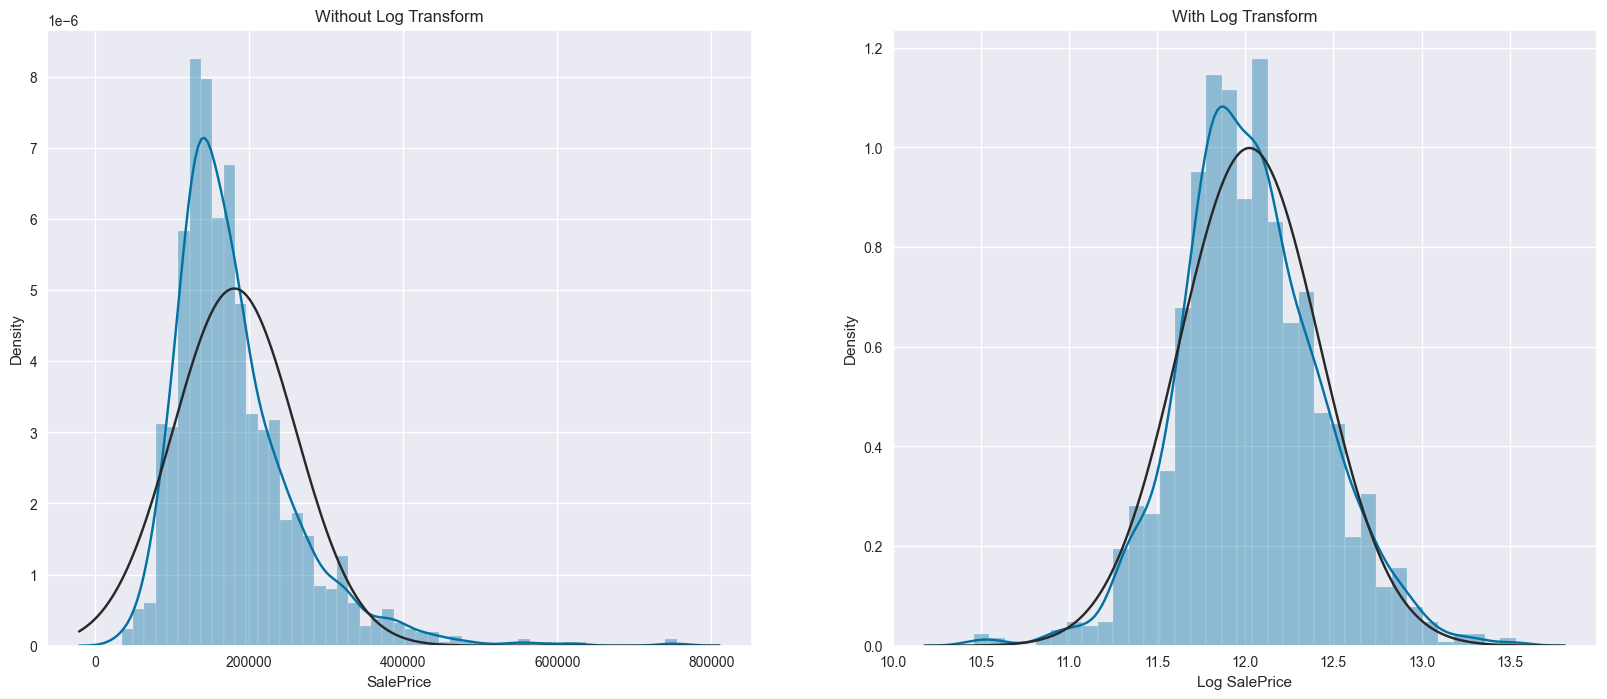

In [371]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title('Without Log Transform')


plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm) #минимум выше нуля
plt.title('With Log Transform')
plt.xlabel('Log SalePrice')
plt.show

Как видно из графиков, прологорифмированные данные гораздо лучше описывают нормальное распределение. Осуществим преобразование:

In [372]:
log_target = np.log(target)
log_target

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

### Обратное разделение данных

До этого мы объединяли тестовые и тренировочные данные удобства обработки. Разделим их обратно для тренировки моделей

In [373]:
train_final = data8.loc[:train0.index.max(), :].copy()
test_final = data8.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [374]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functio

In [375]:
test_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functio

## Выбор модели

В помощью библиотеки `PyCaret` оценим, какие модели будут более эффективно вести себя с нашим набором данных

In [376]:
#_ = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

In [377]:
#compare_models()

Вообще говоря, мне нравится идея построить модель на основе `catboost`. Он отлично показывает себя на нашем наборе данных

## Базовая модель

Обучим нашу модель:

In [378]:
baseline_model = CatBoostRegressor(verbose=0)

In [379]:
baseline_model.fit(train_final, log_target)

## Создание ансамбля

Создадим словарь, сопоставляющий название модели с реальным названием. Из decision tree моделей оставим только catboost, так как он показывает лучшие результаты (в последствии поменяли huber на gbr). Обучим также различные линейные модели:

In [380]:
models = {
    "catboost": CatBoostRegressor(verbose=0),
    "br": BayesianRidge(),
    #"huber": HuberRegressor(),
    "gbr": GradientBoostingRegressor(),
    "ridge": Ridge(),
    "omp": OrthogonalMatchingPursuit()
}

In [381]:
for name, model in models.items():
    model.fit(train_final, log_target)
    print(name + " trained.")

catboost trained.
br trained.
gbr trained.
ridge trained.
omp trained.


## Cравнение

Выполним процедуру перекрестной проверки с 10-ю фолдами

In [382]:
results = {}

kf = KFold(n_splits=10)
for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [383]:
results

{'catboost': array([1.11939824, 1.09829738, 1.11177894, 1.16564442, 1.15872645,
        1.1070967 , 1.12201506, 1.1035697 , 1.12651328, 1.1316318 ]),
 'br': array([1.12598018, 1.10622057, 1.1261536 , 1.16759935, 1.15390021,
        1.14252064, 1.12821036, 1.10266757, 1.19650023, 1.13424067]),
 'gbr': array([1.13664019, 1.1132701 , 1.12319395, 1.17770647, 1.16882508,
        1.10432195, 1.13235971, 1.1158562 , 1.12077861, 1.15009744]),
 'ridge': array([1.13432765, 1.11073799, 1.1258037 , 1.17697758, 1.16161109,
        1.16633572, 1.13270593, 1.10310565, 1.21898343, 1.13443556]),
 'omp': array([1.13223077, 1.09725882, 1.12930056, 1.18311203, 1.15621703,
        1.15856033, 1.12668149, 1.11595193, 1.17872568, 1.15502105])}

Посчитаем среднеквадратичное отклонение по всем фолдам для кажой из моделей:

In [384]:
for name, result in results.items():
    print('\n-------------\n' + name + '\n-------------\n')
    print(np.mean(result))
    print(np.std(result))


-------------
catboost
-------------

1.1244671972457079
0.021309097144032292

-------------
br
-------------

1.1383993370293604
0.026875921713875865

-------------
gbr
-------------

1.1343049718079912
0.02306986948488001

-------------
ridge
-------------

1.1465024301552933
0.03298310496130054

-------------
omp
-------------

1.143305967920284
0.026152400472971227


Как видим, у Huber regression очень высокая среднеквадратичная ошибка, как и стандартное отклонение. Откажемся от него в пользу gbr

In [385]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Ошибка очень мала по сравнению с нашими данными, это прекрасно

<Figure size 1600x1000 with 0 Axes>

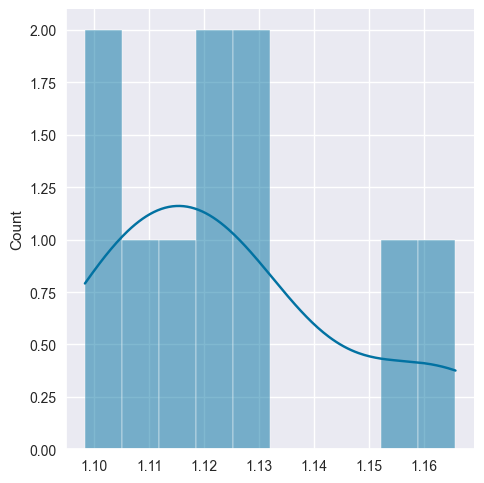

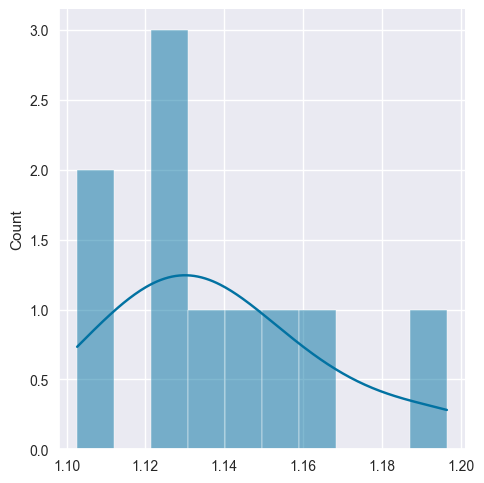

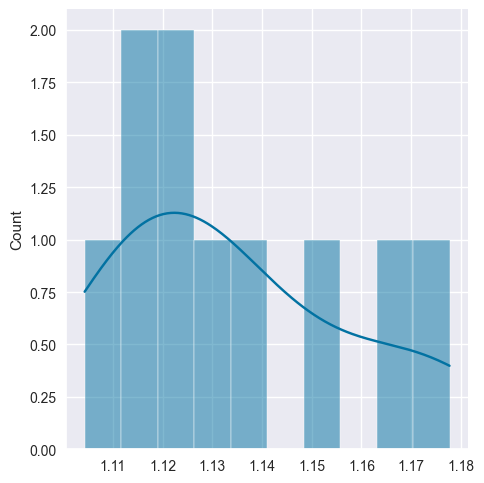

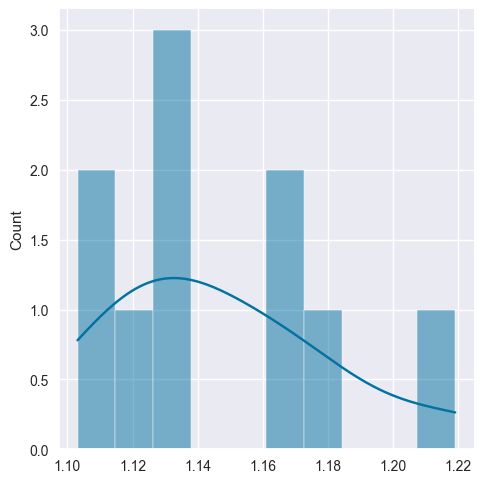

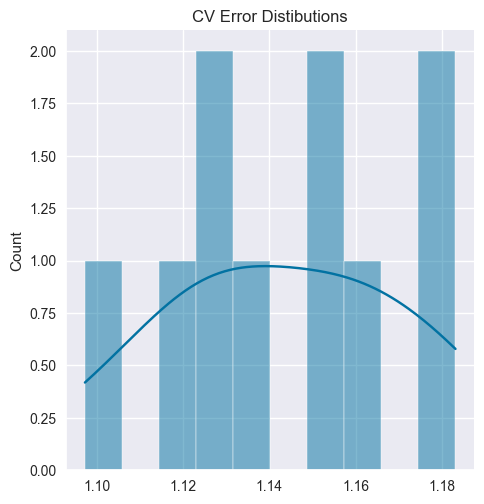

In [386]:
plt.figure(figsize=(16, 10))

for name, model in models.items():    
    sns.displot(results[name], bins=10, kde=True)
    
plt.title("CV Error Distibutions")
plt.show()

## Объединение предсказаний в ансамль

In [387]:
final_predictions = (
    0.5 * np.exp(models['catboost'].predict(test_final)) +
    0.2 * np.exp(models['br'].predict(test_final)) +
    0.2 * np.exp(models['gbr'].predict(test_final)) +
    0.05 * np.exp(models['ridge'].predict(test_final)) +
    0.05 * np.exp(models['omp'].predict(test_final))
)

final_predictions

array([124534.91951798, 158825.46707966, 180685.29758844, ...,
       157970.51837545, 115396.31255126, 219073.828923  ])

## Создание таблицы предсказаний

Вглянем на образец таблицы:

In [388]:
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [389]:
submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,124534.919518
1,1462,158825.467080
2,1463,180685.297588
3,1464,189657.496296
4,1465,189756.736386
...,...,...
1454,2915,82685.784453
1455,2916,81258.025837
1456,2917,157970.518375
1457,2918,115396.312551


In [390]:
submission.to_csv('./submission.csv', index=False, header=True)

In [391]:
#000: base                      : 0.12381
#001: 0.2 * 5                   : 0.12507
#002: 0.2 * 5 + func            : 0.12457
#003: 0.5 cb + func             : 0.12381
